# Explicando modelos de Machine Learning com SHAP Values
## Santander com Ciência
Vinicius Trevisan 2022

---

Resumo em: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

<center><img src="images/1.png" width="600"/></center>


Modelos de Machine Learning normalmente são difíceis de se interpretar. Normalmente nós usamos métricas que avaliam seu desempenho, comparando com uma base de validação, e por vezes ainda avaliamos a estabilidade dos seus públicos e atribuitos. 

Ainda assim, é difícil saber o que está acontecendo lá dentro. Tente raciocinar a lógica de inferência de uma Random Forest com centenas de árvores de decisão, ou uma rede neural que tenha centenas de nerurônios com funções de ativação não lineares e falhe completamente.

## SHAP Values

Documentação: https://shap.readthedocs.io/en/latest/index.html

SHAP (**SH**apley **A**dditive ex**P**lanations) é uma técnica baseada em teoria dos jogos que permite explicar razoavelmente bem o quanto cada atributo está afetando as predições do modelo, de forma global (para todo o dataset) ou até de forma local (para uma única observação).

    Importante: os SHAP values vão nos informar a contribuição de cada atributo na formação da saída do modelo, mas não vai avaliar nem a qualidade dessa predição, nem a estabilidade desse modelo.

Este tutorial irá mostrar como usar os SHAP Values com um exemplo prático.

---
Considerando o California Housing Dataset, podemos isolar uma observação e ver calcular os SHAP Values da predição dela:

`shap.plots.waterfall(shap_values[x])`

<center><img src="images/2.png" width="600"/></center>

No waterfall plot, o eixo X mostra os valores da variável dependente, que no caso é o preço do imóvel. $f(x)$ é o valor que o modelo previu e $\mathbb{E}[f(x)]$ é a média de todas as predições feitas pelo modelo (`model.predict(X)`). 

Os valores de SHAP tem um caráter aditivo, ou seja, eles somados explicam o desvio que essa observação teve da média de todas as observações. É possível ver inclusive a direção para a qual cada atributo "empurrou" a predição, e a consequência desse fato é que a soma de todos os SHAP Values deve ser igual a $\mathbb{E}[f(x)] - f(x)$

O valor absoluto do SHAP mostra o *quanto* aquele atributo influenciou a resposta, seja positiva ou negativamente. No gráfico elas já aparecem em ordem de importância, da maior para a menor.

    Note que esses valores valem APENAS PARA ESTA OBSERVAÇÃO e podem não representar o comportamento do modelo como um todo!

Se quisermos resumir o SHAP para o modelo inteiro, podemos usar um *beeswarm plot*:

`shap.plots.beeswarm(shap_values)`

<center><img src="images/3.png" width="600"/></center>


Nesse gráfico podemos ver cada observação como um ponto em cada linha. No eixo X está o SHAP value e no eixo Y cada atributo. A barra de cores nos mostra se os valores do atributo para aquela observação eram altos ou baixos, então este é efetivamente um gráfico tridimensional.

No exemplo, valores altos da variável MedInc tem SHAP Values positivos e muito altos também, e valores baixos dessa variável terão SHAP values muito negativos. O atributo Latitude tem o efeito contrário. Já os atributos AveRooms, Population e AveBedrms tem um impacto muito pequeno: a maior parte das observações apresentou pequenas variações no SHAP.

# Case prático

Recomendado:
1) [Documentação SHAP - An introduction to explainable AI with Shapley values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
2) [Documentação SHAP - Be careful when interpreting predictive models in search of causal insights](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html)
3) [Documentação SHAP - Explaining quantitative measures of fairness](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.html)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default')

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from scipy.special import softmax

In [4]:
import shap 

### Functions

In [5]:
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = random_forest_model.feature_names_in_
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

In [6]:
def print_feature_importances_shap_values(shap_values, features, softmax = False):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Calculates the softmax version
    if softmax:
        importances_norm = softmax(importances)
        feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
        feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        if softmax:
            print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
        else:
            print(f"{k} -> {v:.4f}")

In [7]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

## Regression

### Importa um dataset de regressão

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
dataset = fetch_california_housing(as_frame = True)

In [10]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [11]:
# Separa as variáveis independentes
X = dataset['data']
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [12]:
# Verifica as dimensões do dataframe
X.shape

(20640, 8)

In [13]:
# Recupera a variável dependente (a target)
y = dataset['target']
y.head(5)

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [14]:
# Separa as bases de teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Cria uma regressão simples

In [15]:
# Prepara uma instância default do RandomForestRegressor
model = RandomForestRegressor()

In [16]:
# Treina o modelo nos dados de treinamento
model.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
# Avalia o modelo
y_pred = model.predict(X_test)
evaluate_regression(y_test, y_pred)

Regression result
MAE: 0.33
MSE: 0.25
RMSE: 0.50
R2: 0.81


In [18]:
# Mostra as feature importances (pelo método da árvore)
print_feature_importances_random_forest(model)

MedInc -> 0.5269
AveOccup -> 0.1379
Longitude -> 0.0879
Latitude -> 0.0872
HouseAge -> 0.0549
AveRooms -> 0.0449
Population -> 0.0308
AveBedrms -> 0.0296


### SHAP values

In [19]:
# Prepara o explainer
explainer = shap.Explainer(model.predict, X_test)

In [20]:
# Calcula os SHAP values - pode levar algum tempo
shap_values = explainer(X_test)

Exact explainer: 4129it [19:59,  3.42it/s]                                                                             


A variável shap_values terá três atributos: `.values`, `.base_values` e `.data`

- `.data` é simplesmente uma cópia dos dados de entrada
- `.base_values` é o valor esperado para a variável dependente (a média dos valores $\mathbb{E}[f(x)]$)
- `.values` tem os SHAP values de cada exemplo. 

In [21]:
shap_values

.values =
array([[-0.78629581, -0.00574974, -0.03331775, ..., -0.26867497,
        -0.44387   , -0.11048016],
       [-0.66483431,  0.00833188, -0.09971777, ..., -0.09694062,
        -0.47201247, -0.13573059],
       [ 0.0678886 ,  0.41593088,  0.03604093, ...,  0.95148139,
         0.24578758,  0.84905082],
       ...,
       [ 2.25895272,  0.03609696,  0.1958283 , ..., -0.0184748 ,
         0.01824945,  0.26986175],
       [-0.58276566,  0.00251631, -0.10000415, ..., -0.03017629,
        -0.57359617, -0.13841338],
       [-0.21438781, -0.05840031, -0.10756192, ..., -0.36956523,
         0.24645913,  0.00404481]])

.base_values =
array([2.14662095, 2.14662095, 2.14662095, ..., 2.14662095, 2.14662095,
       2.14662095])

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
          36.06      , -119.01      ],
       [   2.5313    ,   30.        ,    5.03938356, ...,    2.67979452,
          35.14      , -119.46      ],
       [   3.4801    ,   52.        

## SHAP - Avaliação Global

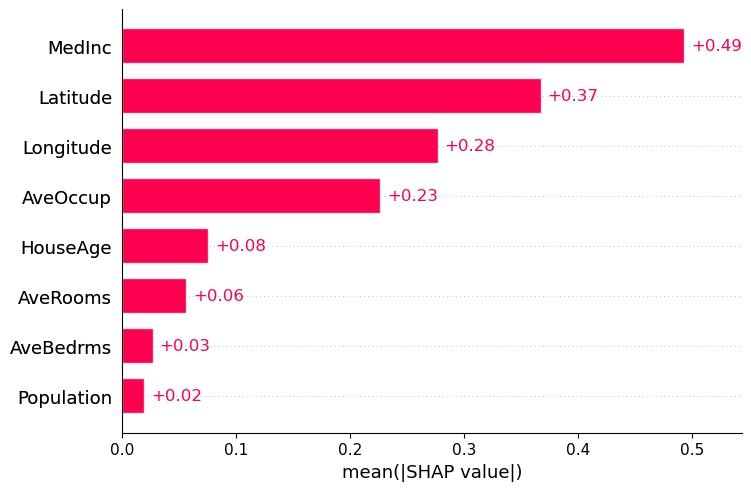

In [22]:
# Plota a avaliação global
shap.plots.bar(shap_values)

In [23]:
# Mostra as feature importances (baseado no SHAP)
print_feature_importances_shap_values(shap_values, X_test.columns)

MedInc -> 0.4928
Latitude -> 0.3671
Longitude -> 0.2769
AveOccup -> 0.2264
HouseAge -> 0.0757
AveRooms -> 0.0565
AveBedrms -> 0.0273
Population -> 0.0196


In [24]:
# Mostra as feature importances (pelo método da árvore)
print_feature_importances_random_forest(model)

MedInc -> 0.5269
AveOccup -> 0.1379
Longitude -> 0.0879
Latitude -> 0.0872
HouseAge -> 0.0549
AveRooms -> 0.0449
Population -> 0.0308
AveBedrms -> 0.0296


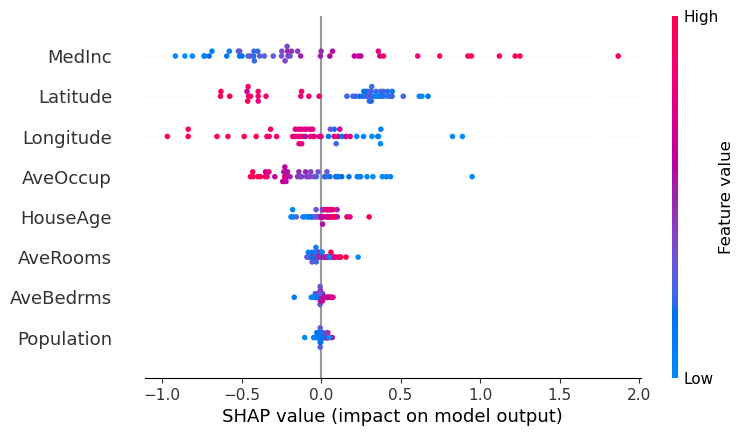

In [25]:
shap.plots.beeswarm(shap_values.sample(50))

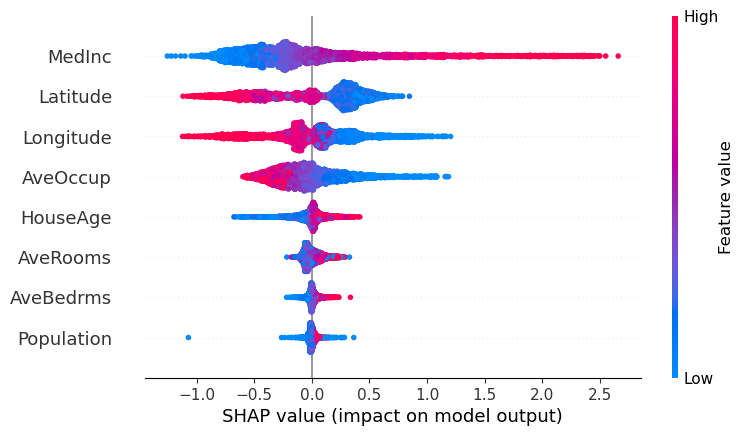

In [26]:
shap.summary_plot(shap_values)

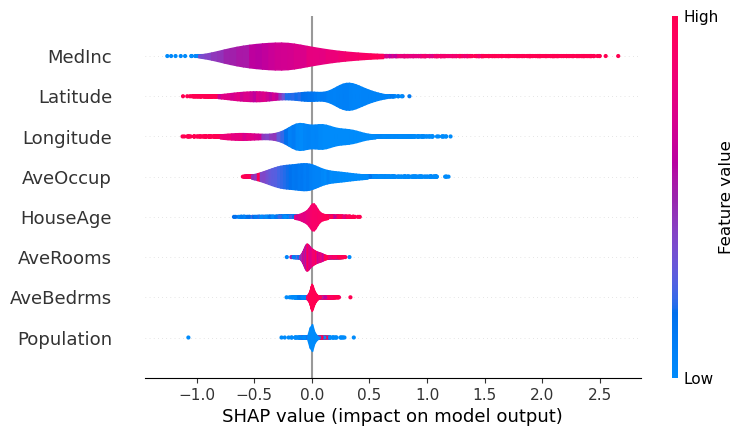

In [27]:
shap.summary_plot(shap_values, plot_type='violin')

## SHAP - Avaliação Local
(para uma única observação)

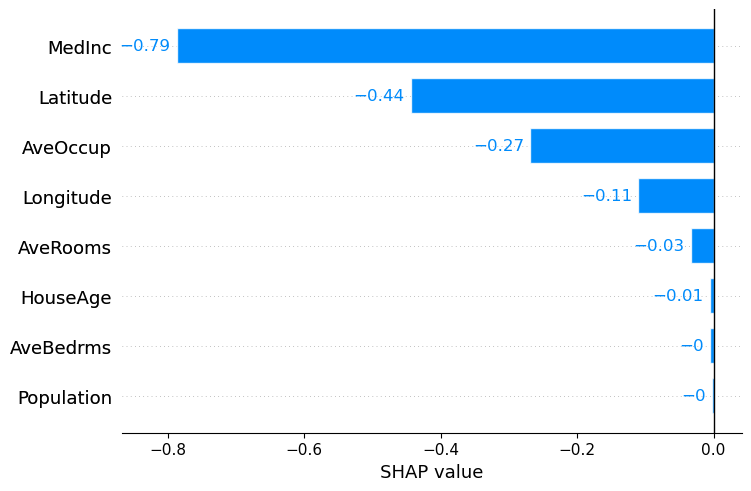

In [28]:
shap.plots.bar(shap_values[0])

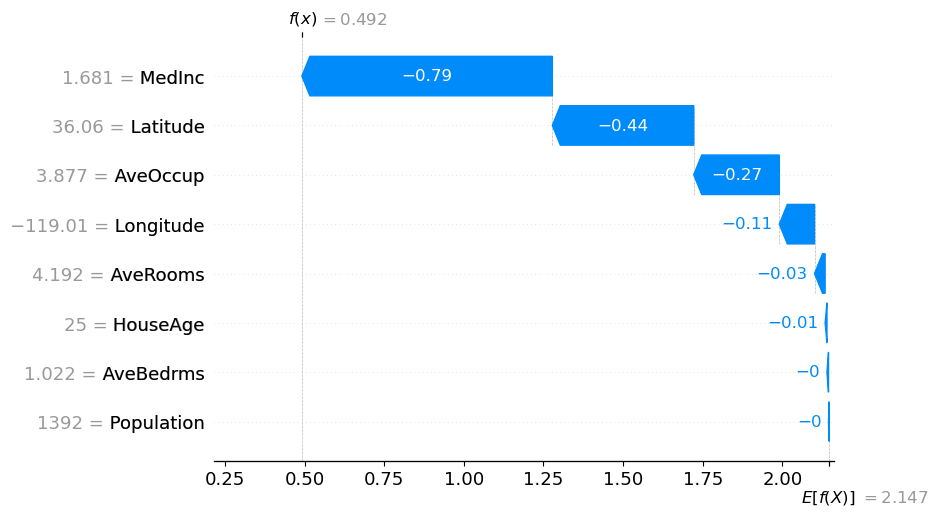

In [29]:
shap.plots.waterfall(shap_values[0], max_display=10)

In [33]:
shap.initjs()
shap.plots.force(shap_values[3])

Se a force plot não funcionar, uma imagem:
<center><img src="images/forceplot.png" width="900"/></center>

## Calculando os SHAP Values
(Porque afinal de contas todos queremos ser data experts, não?)

Referências
1) https://towardsdatascience.com/shap-shapley-additive-explanations-5a2a271ed9c3
2) https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
3) [Artigo Shapley Values](https://doi.org/10.1515/9781400881970-018)
4) [Artigo SHAP Values](https://arxiv.org/pdf/1705.07874.pdf)

---
Os SHAP Values são baseados nos Shapley Values, que nasceram da teoria dos jogos.

Imagine que você tem um exército e precisa defender contra um ataque inimigo, e você dispõe de tanques e soldados. Se você despachar os tanques primeiro eles podem segurar os inimigos por algum tempo, e só quando eles se aproximarem os seus soldados precisarão entrar em cena. Provavelmente essa é uma estratégia bastante efetiva e você terá poucos soldados aliados mortos.

Se por outro lado você mandar primeiro os soldados e deixar os tanques para depois, você pode até conseguir se defender, mas ao custo de muito mais vidas.

Essa é a intuição dos Shapley Values: descobrir a contribuição de cada participante no resultado do jogo

<center><img src="images/4.jpeg" width="600"/></center>

Ou alternativamente,

$$\varphi(v) = \frac{1}{n} \sum_{S \subseteq N \setminus \{i\}} \binom{n-1}{|S|}^{-1} \left(v(S \cup \{i\}) - v(S)\right)$$


--- 
Os Shapley Values são bastante complexos e custosos de se calcular. No nosso caso, inclusive, nem sempre conseguimos amostras de dados que tenham todas as possíveis combinações de atributos. Isso prejudica ou até impede o uso dos Shapley Values no contexto de IA.

Aí entram os SHAP Values, que são uma aproximação razoável e que pode ser usada em modelos de Machine Learning.

--

Digamos que o modelo use quatro features: $f_1$, $f_2$, $f_3$ e $f_4$. Primeiramente nós separamos um pedaço da nossa base e chamamos de "base de background".

Em seguida, precisamos calcular todas as combinações de atributos, mas não podemos simplesmente remover um deles senão o modelo não irá funcionar.

Se o vetor $z = (1, 0, 1, 0)$ significa que estamos usando os atributos $\{f_1, f_3\}$ e descartando $\{f_2, f_4\}$, nós podemos simplesmente pegar $\{f_1 = x_1, f_3 = x_3\}$ de uma observação $x$ da base original e amostrar $\{f_2 = b_2, f_4  = b_4\}$ de diferentes observações da base de background, assim elas afetam o modelo aleatoriamente e não irão contribuir corretamente para o cálculo da importância.

Nós apresentamos cada possível combinação $z_{(i)}$ para o modelo e obtemos uma predição $y_{(i)}$.

<center><img src="images/5.jpeg" width="800"/></center>

Além disso, podemos calcular pesos que são relacionados a cada combinação:

<center><img src="images/6.png" width="600"/></center>

De posse dos pesos e das predições, podemos calcular uma regressão linear que gere os valores de SHAP de acordo com os valores de cada atributo. E dessa forma o SHAP é calculado para todas as observações do modelo.
